In [2]:
#| default_exp wave

# Wave Resistance (wave)

> Functions for calculating the forces on the ship due to waves

This section provides the functions necessary to calculate the resistance caused by waves

In [3]:
#| export
import numpy as np
from scipy.integrate import quad
from scipy.special import iv, kn
from fastcore.test import *

## STAWAVE-1

STAWAVE-1 s a simplficied method for ship experiencing limited heave and pitch it was developed by Boom, 2013, and is a practical solution due to its low calculation complexity and relatively small number of variables.

STAWAVE-1 has been validated and can be applied when following conditions are met

- Heave and Pitch are small with the vertical acceleration of the bow $<0.05g \approx 0.49ms^{-2}$
- Thee wave direction $x$ is between $-45^\circ <x < -45^\circ$

**ITTC equations**: G-1

In [4]:
#| export

def stawave1_fn(
    beam:float, #the beam of the ship [m]
    wave_height:float, #Significant wave height of wind waves [m]
    length:float, #The length of the bow on the water line [m]. See documentation for more details
    water_density:float = 1026, #this should be for the current temperature and salinity [kg/m^3]
            gravity:float  = 9.81
            )-> float: # Wave resistance [kg*m/s^2]
    
    "STAWAVE-1 finds the resistance caused by bow waves for ships experiencing low heave and pitch"
    
    
    return (1/16)* water_density * gravity * wave_height**2 * beam * np.sqrt(beam/length)
    

In [5]:
stawave1_fn(beam = 20, wave_height = 1, length =5)

25162.65

In [6]:
#| hide


test_eq(stawave1_fn(20, 2, 5), 100650.6)

## The modified Pierson-Moskowitz spectrum

In order to calcualte the force exerted on the vessel by the waves, the wave spectra must be calculate. For this the modified Pierson-Moskowitz spectrum [XXXcitationxxx] algorithm is typically used.



$$S_\eta(\omega) =\frac{A_{fw}}{\omega^5} \textrm{exp}(-\frac{B_{fw}}{\omega^4})$$


$$A_{fw} = 173\frac{H_{W1/3}^2}{T_{01}^4}$$

$$B_{fw} = \frac{691}{T_{01}^4}$$

Where

- $\omega$ is the circular frequency of regular waves
- $H_{W1/3}$ is the significant wave height of swell and wind waves
- $T_{01}$ is the wave encounter period

**ITTC equations**: 10

In [7]:
#| export

def modified_pierson_moskowitz_spectrum(omega:float, #The circular frequency [rads/s]
                                        H_W1_3:float, #Significant wave height of Wind and Swell waves [m]
                                        #T_01:float#
                                        )->float: #The energy density spectrum at the point omega [s]
    
    T_01 = 2*np.pi * omega
    A_fw = 173 * (H_W1_3 ** 2) / (T_01 ** 4)
    B_fw = 691 / (T_01 ** 4)
    S_eta = (A_fw / (omega ** 5)) * np.exp(-B_fw / (omega ** 4))
    return S_eta

As an example of the modified pierson moskowitz spectrum consider the case below

In [8]:
omega = 1
H_W1_3 = 2.0
T_01 = 5.0

S_eta = modified_pierson_moskowitz_spectrum(omega, H_W1_3)
print(S_eta)

0.28499477886766


## STAWAVE-2

The resistance experienced by the ship from waves is calulated using the below process

Wave transfer function is given by
$$R_{wave} = R_{AWRL} + R_{AWML}$$

Where 

$$ R_{AWML} = \frac{4 \rho_s g \zeta_A^2B^2}{ L_{pp} }\bar{r}_{aw}(\omega)   $$

with

$$\bar{r}_{aw}(\omega) = \bar{\omega}^{b_1} \textrm{exp}\left\{ \frac{b_1}{d_1}(1 - \omega^{-d_1}) \right\} a_1 \textrm{Fr}^{1.5} \textrm{exp}(3.50 \textrm{Fr})$$


$$\bar{\omega} = \frac{\sqrt{\frac{L_{pp}}{g}}\sqrt[3]{k_{yy}}}{1.17 \textrm{Fr}^{-0.143}}\omega$$

$$a_1 = 60.3 C_B^{1.34} $$

$$b_1 = \begin{cases} 11.0 & \bar{\omega}<1  \\ -8.5 & \bar{\omega}\geq1 \end{cases}$$


$$d_1 = \begin{cases} 14.0 & \bar{\omega}<1  \\ -566(\frac{L_{pp}}{B})^{-2.66} & \bar{\omega}\geq1 \end{cases}$$

$$ R_{AWRL} = \frac{1}{2} \rho_s g \zeta_A^2B \alpha_1(\omega) $$

$$ \alpha_1(\omega) = \frac{\pi^2 I_1^2 ( 1.5 k T_M ) }{ \pi^2 I_1^2 ( 1.5 k T_M ) + K_1^2 ( 1.5 k T_M ) }f_1 $$

$$ f_1 = 0.692 \left( \frac{V_S}{\sqrt{T_M g}} \right)^{0.769} + 1.81 C_B^{6.95} $$

once R_{AWRL}$, and $R_{AWML}$$ are obtained then the added resistance to the ship  can be found by integrating the below equation.
$$R_{AWL} = 2\int_{0}^{\infty} \frac{R_{wave}}{\zeta_A^2}S_{\eta}(\omega)d\omega$$


Where the variables of the above equations are

- $B$ Beam of ship
- $\rho_s$ water density at current ship conditions
- $g$ force of gravity
- $Fr$ Froude number
- $\omega$ wave frequency
- $k$ ciruclar wave number in rads/s
- $S_eta$ frequency spectrum of ocean waves. JONSWAP or ther methods can be used as appropriate.
- $C_B$ block coefficient
- $V_s$ ships speed in m/s
- $k_{yy}$ non-dimensional radius of gyration in the lateral direction
- $L_{pp}$ ship length between perpendiculars
- $T_M$ draught at midship
- $I_t$ modified Bessel Function of the first kind of order 1
- $K_t$ modified Bessel Function of the second kind of order 1
- $\zeta_A$ The amplitude of the wave/significant wave height

**ITTC equations**: G-12


In [102]:
#| export

def _a_1(C_B):
    return 60.3 * C_B**1.34

def _bar_omega_fn(omega, L_pp, g, k_yy, Fr):
    return (np.sqrt(L_pp / g) * (k_yy**(1/3))) / (1.17 * 1/ np.power(Fr, 0.143)) * omega

def _b_1(bar_omega):

    result = np.where(bar_omega < 1, 11, -8.5)
    return result

def _d_1(bar_omega, L_pp, B):

    result = np.where(bar_omega < 1, 14, -566 * 1/np.power(L_pp/B, 2.66))
    return result


def _r_aw(bar_omega, b_1, d_1, a_1, Fr):
    return (bar_omega**b_1) * np.exp((b_1 / d_1) * (1 - (1/ np.power(bar_omega, d_1)))) * a_1 * Fr**1.5 * np.exp(3.50 * Fr)


def _R_AWML(rho_s, g, zeta_A, B, L_pp, r_aw):
    return ((4 * rho_s * g * zeta_A**2 * B**2) / L_pp ) * r_aw


def _f_1(V_S, T_M, g, C_B):
    return 0.692 * (V_S / np.sqrt(T_M * g))**0.769 + 1.81 * C_B**6.95

def _alpha_1(I_1, K_1, f1):
    return ((np.pi**2 * I_1**2 ) / (np.pi**2 * I_1**2  + K_1**2 ))*f1


def _R_AWRL(rho_s, g, zeta_A, B, alpha_1):
    return 0.5 * rho_s * g * zeta_A**2 * B * alpha_1

In [103]:
#| export
def calculate_R_wave(omega:float, # circular wave frequency [rads/s]
                     C_B:float, # block coefficient [dimensionless]
                     L_pp:float, # Length between perpendiculars [m]
                     k_yy:float, # radius of gyration in the lateral direction [dimensionless]
                     Fr:float, # Froude number [dimensionless]
                     zeta_A:float, # wave amplitude [m]
                     B:float, # ship breadth [m]
                     k:float, # circular wave number [rads/m]
                     T_M:float, # draught at midship [m]
                     V_s:float, # speed through water [m/s]
                     rho_s:float = 1025, # water density [kg/m^3]
                     g:float = 9.81 # acceleration due to gravity [m/s^2]
                     ) -> tuple: #Function outputs the wave transfer function as well as the component parts R_AWRL and R_AWML
    a1 = _a_1(C_B)
    bar_omega = _bar_omega_fn(omega, L_pp, g, k_yy, Fr)
    b1 = _b_1(bar_omega)
    d1 = _d_1(bar_omega, L_pp, B)
    r_aw_val = _r_aw(bar_omega, b1, d1, a1, Fr)
    R_AWML_val = _R_AWML(rho_s, g, zeta_A, B, L_pp, r_aw_val)
    
    I_1 = iv(1, 1.5 * k * T_M)
    K_1 = kn(1, 1.5 * k * T_M) 
    f1 = _f_1(V_s, T_M, g, C_B)
    alpha1 = _alpha_1(I_1, K_1, f1)
    R_AWRL_val = _R_AWRL(rho_s, g, zeta_A, B, alpha1)
    R_wave = R_AWRL_val + R_AWML_val
    
    return R_wave, R_AWRL_val, R_AWML_val

def R_AWL(#omega:float, # circular wave frequency [rads/s]
          zeta_A:float, # wave amplitude [m]
          B:float, # ship breadth [m]
          L_pp:float, # Length between perpendiculars [m]
          V_s:float, # speed through water [m/s]
          T_M:float, # draught at midship [m]
          C_B:float, # block coefficient [dimensionless]
          k_yy:float, # radius of gyration in the lateral direction [dimensionless]
          Fr:float, # Froude number [dimensionless]
          k:float, # circular wave number [rads/m]
          rho_s:float = 1025, # water density [kg/m^3]
          g:float = 9.81, # accerleation due to gravity [m/s^2]
          S_eta:object = None, #A function calculating the wave spectrum 
          **kwargs)->tuple: # The added wave resistance, the wave resistance from reflection, the wave resistsance from pitching
    
    def integrand(omega: float) -> tuple:
        R_wave, R_AWRL_val, R_AWML_val = calculate_R_wave(omega = omega, C_B = C_B, L_pp = L_pp, k_yy = k_yy, 
                                                          Fr = Fr , zeta_A = zeta_A, B = B, k = k, T_M = T_M, 
                                                          V_s = V_s, rho_s = rho_s, g = g)
        common_factor = (1 / (zeta_A**2)) * S_eta(omega, **kwargs)
        return common_factor * R_wave, common_factor * R_AWRL_val, common_factor * R_AWML_val

    def integrand_n(omega: float, n: int) -> float:
        return integrand(omega)[n]

    result_0, _ = quad(lambda omega: integrand_n(omega, 0), 0, np.inf)
    result_1, _ = quad(lambda omega: integrand_n(omega, 1), 0, np.inf)
    result_2, _ = quad(lambda omega: integrand_n(omega, 2), 0, np.inf)
    
    return 2 * result_0, 2 * result_1, 2 * result_2

In [104]:
# Ship parameters
L_pp = 250  # meters
V_s = 10  # meters per second
beaufort_scale = 5
Fr = 0.3

# Example values for other parameters (adjust based on the specific ship)
omega = 0.3 # circular wave frequency [rads/s]
g = 9.81  # m/s^2, force of gravity
k = omega**2 / g # circular wave number [rads/m]
rho_s = 1025  # kg/m^3, water density
zeta_A = 1  # meters, significant wave height
B = 32  # meters, beam of the ship
C_B = 0.7  # block coefficient
T_M = 12  # meters, draught at midship
k_yy = 0.25  # non-dimensional radius of gyration in the lateral direction
I_1 = iv(1, 1.5 * k * T_M)
K_1 = kn(1,  1.5 * k * T_M) 


# Calculate R_wave
R_wave = calculate_R_wave(omega, C_B, L_pp, k_yy, Fr, zeta_A, B, k, T_M, V_s, rho_s, g)

R_wave 

(254.37418745722928, 254.37418745722928, 7.3094040083970525e-62)

In [58]:
R_AWL(zeta_A, B, L_pp, V_s, T_M, C_B, k_yy, Fr, k, rho_s, g, S_eta = modified_pierson_moskowitz_spectrum, H_W1_3 = zeta_A)

(15.931104238927267, 15.921394511613968, 0.009709727327267468)

In [123]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, interp1d
PATH = os.path.join(os.path.dirname(os.getcwd()), 'data')

In [60]:
# helper function to calculate some wave parameters
def calculate_params(wave_length):
    celerity = np.sqrt(9.81*wave_length/(2*np.pi))
    period = wave_length / celerity
    omega = np.sqrt(2*np.pi*9.81 / wave_length) 
    return celerity, period, omega

In [116]:
# load data
data = pd.read_excel(PATH+'\\excel.xlsx', sheet_name='kim_2021_slngc')

In [124]:
dff = pd.DataFrame({
    'vs': [10.134 for i in range(19)],  
    'wave_amplitude': data.x_new.values*290/ 40,
    'ta': [ 11.5 for i in range(19)],
    'b': [ 45 for i in range(19)], 
    'lpp': [ 290 for i in range(19)],
    'kyy_value': [0.25 for i in range(19)], 
    'cb': [0.79 for i in range(19)],  
    'rho': [1020 for i in range(19)],
    'T_01': [i for i in calculate_params(wave_length=data.x_new.values*290)[1]], 
    'HW13': [1 for i in range(19)],    
    'omega': [i for i in calculate_params(wave_length=data.x_new.values*290)[2]], 
    })
dff_ = dff.values.tolist()

In [126]:
# function to compute RWAVE by calling the calculate_R_wave function
def compute_raw(df):
  df = df.copy()
  raw_force_dict = dict()
  generator = [(calculate_R_wave(omega=df['omega'].iloc[i], Fr=0.19, k = df['omega'].iloc[i]**2/9.81, 
                  V_s=df['vs'].iloc[i], zeta_A=df['wave_amplitude'].iloc[i], 
                    g=9.81,T_M=df['ta'].iloc[i], 
                    B=df['b'].iloc[i], L_pp=df['lpp'].iloc[i], 
                    k_yy=df['kyy_value'].iloc[i], C_B=df['cb'].iloc[i],
                    rho_s=df['rho'].iloc[i])[0] for i in range(0, df.shape[0]))]
    
  for i in generator:
        RAW_FORCE = []
        for j in i: RAW_FORCE.append(j) # list of content of generator
        for y in RAW_FORCE: raw_force_dict.setdefault('Force', []).append(y) # name , array of data for name
  return pd.DataFrame(raw_force_dict)

In [127]:
# call compute_raw
resistance_force = compute_raw(df=dff)

In [120]:
# Helper function to calculate the non-dimensionless added wave resistance
def calculate_caw(*, output, density, wave_amplitude, b, lpp):
    top = output * lpp
    bottom = density * 9.81 * wave_amplitude**2 * b**2
    return top/bottom
C_AW = calculate_caw(output=resistance_force['Force'].values, density=1020, 
                     wave_amplitude=dff['wave_amplitude'],
                     b=dff['b'], lpp=dff['lpp'])


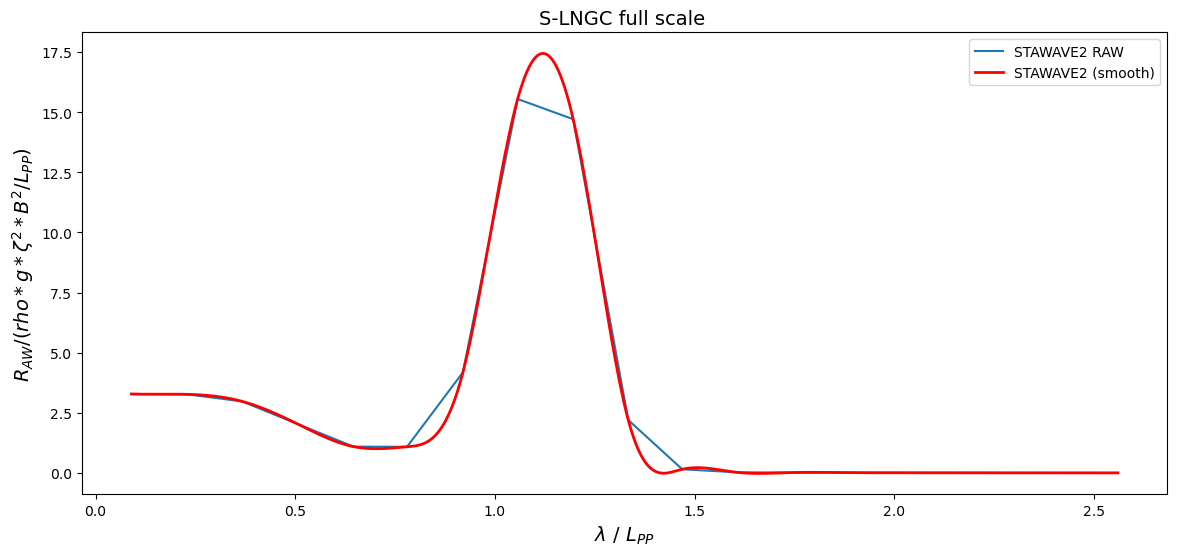

In [128]:
# plot output for the non-dimensional wave resistance
plt.figure(figsize=(14, 6))
plt.plot(data.x_new, C_AW, label='STAWAVE2 RAW')
plt.plot(np.linspace(data.x_new.min(), data.x_new.max(), 500), make_interp_spline(data.x_new, C_AW)(np.linspace(data.x_new.min(), data.x_new.max(), 500)),
            c='red', label=f"STAWAVE2 (smooth)", linewidth=2,)
plt.xlabel('$\lambda$ / $L_{PP}$', fontsize=14)
plt.ylabel('$R_{AW}/(rho * g * \zeta^2 * B^2 / L_{PP})$', fontsize=14)
plt.title('S-LNGC full scale ', fontsize=14)
plt.legend(loc=1, fontsize=10);

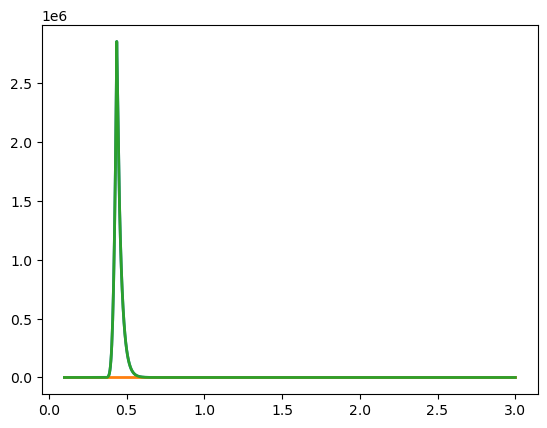

<function __main__.<lambda>(omega)>

In [109]:

transfer_function = lambda omega: (calculate_R_wave(omega = omega, C_B = C_B, L_pp = L_pp, k_yy = k_yy, 
                                                    Fr = Fr , zeta_A = zeta_A, B = B, k = k, T_M = T_M, V_s = V_s, rho_s = rho_s, g = g))

multipliers = [3, 2, 1, 1/2, 1/4, 1/8]

pierson2 = lambda omega: modified_pierson_moskowitz_spectrum(omega, H_W1_3=1)
x = np.linspace(0.1, 3, 1000)
y = (np.array([transfer_function(z) for z in x]))
y2 = (np.array([pierson2(z) for z in x]))


fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

plt.show()
pierson2

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()